# 実験1
細い所はわからないので、とりあえず、下記9つをdefault setupで行ってみた。  
'simple', 'simple_adversary', 'simple_crypto',　'simple_push', 'simple_reference', 'simple_speaker_listener',　'simple_spread', 'simple_tag', 'simple_world_comm'

#### env pars
- parser.add_argument("--max-episode-len", type=int, default=25, help="maximum episode length")
- parser.add_argument("--num-episodes", type=int, default=60000, help="number of episodes")
- parser.add_argument("--num-adversaries", type=int, default=0, help="number of adversaries")
- parser.add_argument("--good-policy", type=str, default="maddpg", help="policy for good agents")
- parser.add_argument("--adv-policy", type=str, default="maddpg", help="policy of adversaries")

#### learning pars
- parser.add_argument("--lr", type=float, default=1e-2, help="learning rate for Adam optimizer")
- parser.add_argument("--gamma", type=float, default=0.95, help="discount factor")
- parser.add_argument("--batch-size", type=int, default=1024, help="number of episodes to optimize at the same time")
- parser.add_argument("--num-units", type=int, default=64, help="number of units in the mlp")


#### results data
- 次研のGPU, gmoappどちらでも実験しているが、(たぶん変わらないので)ここではgmoappの結果を使う
- maddpg/experiments/exp_results/gmoapp/

In [63]:
%matplotlib inline
import os
import os.path as osp
import re
import glob
from IPython.display import HTML

exp_dir = osp.abspath('../exp_results/gmoapp/')
par_dir = osp.abspath('../params/')


def play_video(exp_dir, scenario, n_epi, width=500, height=300):
    each_exp_dir = get_exp_dir(exp_dir, scenario)
    link_dir = osp.join('./videos', osp.basename(each_exp_dir))
    if not osp.lexists(link_dir):
        os.symlink(each_exp_dir, link_dir)
    fn_video = osp.join(link_dir, 'videos/video-%d.mp4' % n_epi)
    return _play_video(fn_video, width, height)

def _play_video(fn_video, width, height):
    print(fn_video)
    return HTML("""
    <video width="%d" height="%d" controls>
      <source src="%s" type="video/mp4">
    </video>""" % (width, height, fn_video))

def get_exp_dir(exp_dir, scenario):
    for fn in glob.glob(osp.join(exp_dir, '*')):
        if re.search('exp_' + scenario + '_\d', fn):
            return fn


## 1. Learning curves

In [2]:
plt.rcParams['font.size'] = 14
        
def get_colns(df, colns):
    if colns is not None:
        return colns
    n_agents = df.shape[1] - 1
    colns = ['step'] + ['agent%d_rew' % i for i in range(n_agents)]
    return colns


def plot_lcs(fn_rewards, colns=None, display_table=False):
    fn_scenarios = 'default_scenarios_cpu_setup1.dic'
    scenarios = eval(open(osp.join(par_dir, fn_scenarios)).read())['scenarios']
    
    fig, axes = plt.subplots(3, 3, figsize=(21, 16))
    axes = axes.flatten()
    for i, scenario in enumerate(scenarios):
        each_exp_dir = get_exp_dir(exp_dir, scenario)
        fn_lc = osp.join(each_exp_dir, 'learning_curves', fn_rewards)
        df_lc = pd.read_csv(fn_lc, header=None, index_col=False, sep=' ')
        df_lc = df_lc.dropna(axis='columns', how='all')
        if display_table:
            display(df_lc.head(3))
        df_lc.columns = get_colns(df_lc, colns)
        df_lc.plot(x='step', style='-o', fontsize=16, ax=axes[i], title=scenario, alpha=0.5)
    plt.tight_layout()


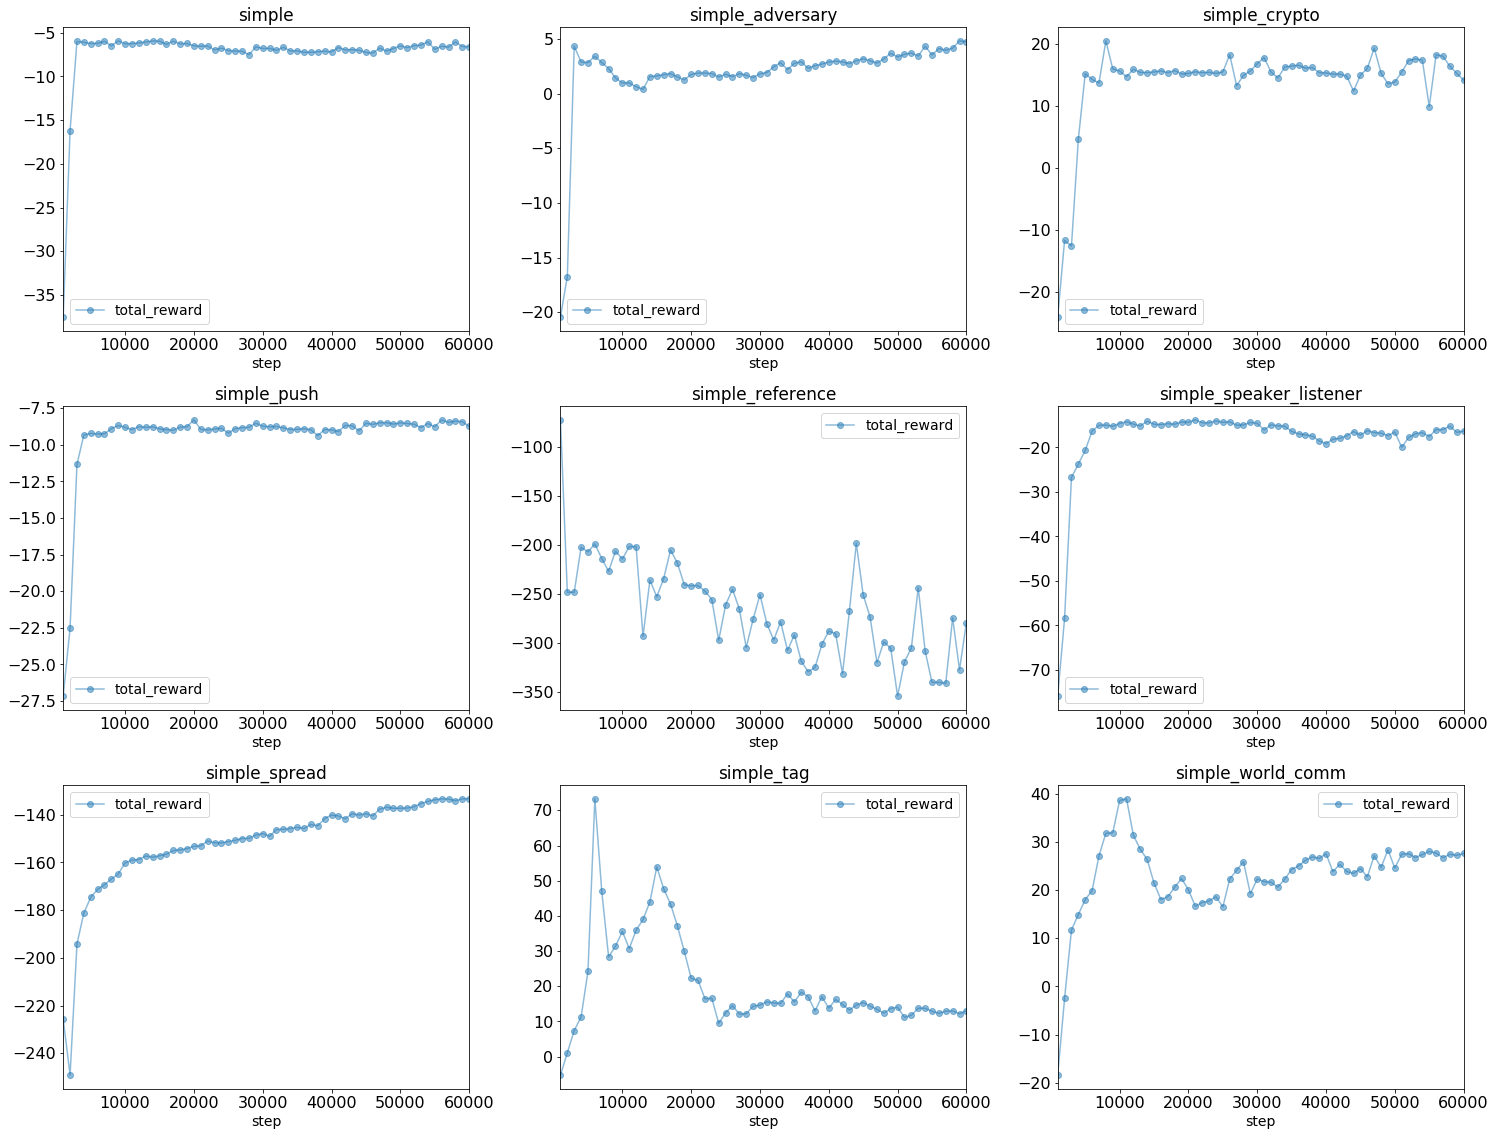

In [3]:
plot_lcs('rewards.csv',  colns=['step', 'total_reward'])

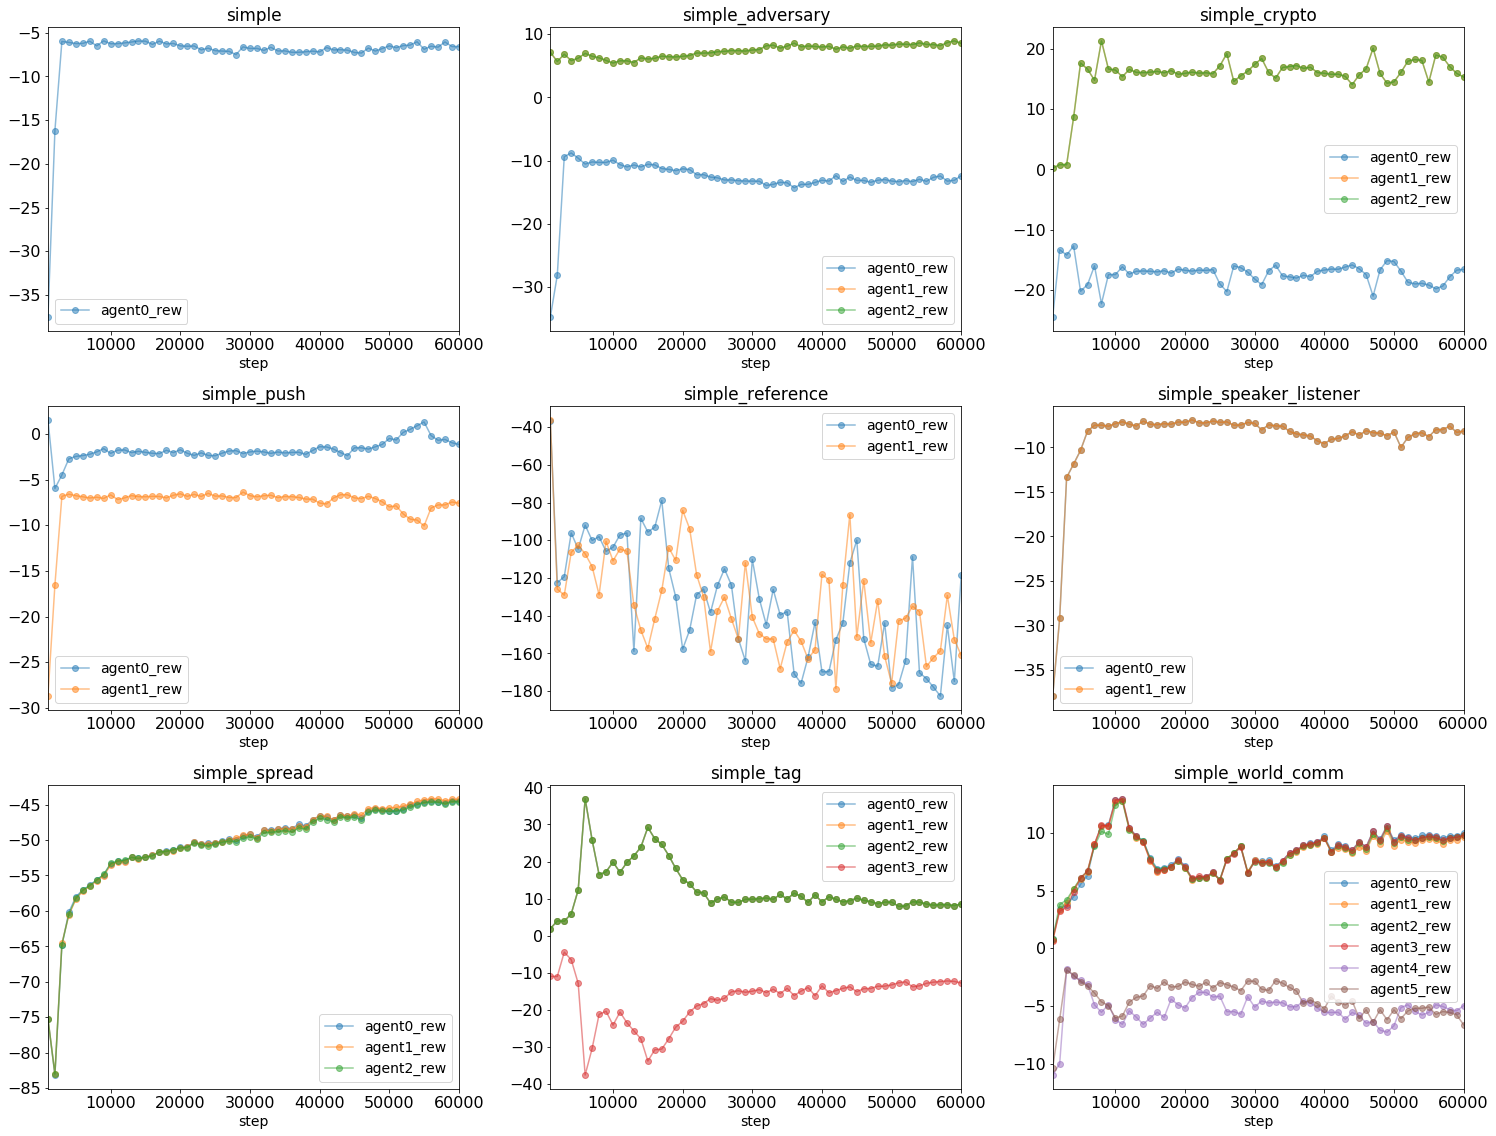

In [4]:
plot_lcs('agents_rewards.csv')

In [5]:
from multiagent.environment import MultiAgentEnv
import multiagent.scenarios as scenarios

def action_space(scenario):
    fn = osp.join('../../../multiagent-particle-envs/multiagent/scenarios/%s.py' % scenario)
    scenario = scenarios.load(fn).Scenario()
    world = scenario.make_world()
    env = MultiAgentEnv(world, scenario.reset_world, scenario.reward, scenario.observation)
    print(env.action_space)

## 2. モデルごとの考察

### 2-1. simple
#### setup
- world: 1 agent + 1 landmark
- obs: agentのv, landmarkへのrel. vector
- act: 1dim（下記参照）
- reward: -1 x (agent0とlandmarkの距離)

#### results
- 最もシンプルなenv
- learning curveより、epi ~ 1000で、問題なく学習できている。
- videoでも問題無いことが確認できる。


In [66]:
scenario = 'simple'
action_space(scenario)
# <- no-move, left, right, down, up = 0, 1, 2, 3, 4
# で５種類のdiscrete valueが1次元

n_epi = 60000
play_video(exp_dir, scenario, n_epi)

[Discrete(5)]
./videos/exp_simple_13-03-2018_16-09-17/videos/video-60000.mp4


### 2-2. simple_adversary
#### setup
- world: N good agents + 1 adversary + N landmark
    - here, N = 2
- obs
    - good agents:
    - adversary:
- act: 1dim（下記参照）
- reward: -1 x (agent0とlandmarkの距離)

#### results

In [52]:
scenario = 'simple_adversary'
action_space(scenario)
# adversary, good1, good2

[Discrete(5), Discrete(5), Discrete(5)]


In [47]:
play_video(exp_dir, scenario, n_epi = 3000, width=500, height=300)

/Users/usr0102292/analysis/research/18-1Q/maddpg/experiments/exp_results/gmoapp/exp_simple_adversary_13-03-2018_16-09-17


In [53]:
play_video(exp_dir, scenario, n_epi = 10000, width=500, height=300)

./videos/exp_simple_adversary_13-03-2018_16-09-17/videos/video-10000.mp4


In [55]:
play_video(exp_dir, scenario, n_epi = 60000, width=500, height=300)

./videos/exp_simple_adversary_13-03-2018_16-09-17/videos/video-60000.mp4


### simple_push

In [58]:
scenario = 'simple_push'
print(action_space(scenario))
play_video(exp_dir, scenario, n_epi = 4000, width=500, height=300)

[Discrete(5), Discrete(5)]
None
./videos/exp_simple_push_13-03-2018_16-09-17/videos/video-4000.mp4


In [60]:
play_video(exp_dir, scenario, n_epi = 50000, width=500, height=300)

./videos/exp_simple_push_13-03-2018_16-09-17/videos/video-50000.mp4


### simple_spread_listener

In [61]:
scenario = 'simple_speaker_listener'
print(action_space(scenario))
play_video(exp_dir, scenario, n_epi = 3000, width=500, height=300)

[Discrete(3), Discrete(5)]
None
./videos/exp_simple_speaker_listener_13-03-2018_16-09-16/videos/video-3000.mp4


In [64]:
play_video(exp_dir, scenario, n_epi = 10000)

./videos/exp_simple_speaker_listener_13-03-2018_16-09-16/videos/video-10000.mp4


In [65]:
play_video(exp_dir, scenario, n_epi = 60000)

./videos/exp_simple_speaker_listener_13-03-2018_16-09-16/videos/video-60000.mp4


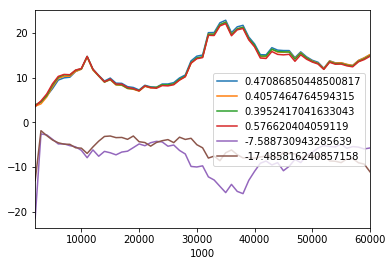

In [76]:
a = pd.read_csv('../exp_results/gmoapp/exp_simple_world_comm_13-03-2018_22-10-22/learning_curves/agents_rewards.csv', sep=' ')
a.iloc[:, :-1].plot(x='1000')
# a